In [311]:
# Standard 
import os, sys , copy ,shutil, logging, csv, json, logging
logger = logging.getLogger()
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from scipy import optimize


# Import all the streamm modules
from streamm import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
os.chdir('/Users/tkemper/Projects/DApolymers/')

In [3]:
proj_tag = 'res_et2'
proj_i = project.Project('DAPpolymers_%s'%(proj_tag))
proj_i.load_json()

Resource tag found peregrine 
Reading in resource json file res_peregrine.json 
Resource tag found peregrine 
Reading in resource json file res_peregrine.json 
Resource tag found peregrine 
Reading in resource json file res_peregrine.json 
Resource tag found peregrine 
Reading in resource json file res_peregrine.json 
Resource tag found peregrine 
Reading in resource json file res_peregrine.json 
Resource tag found peregrine 
Reading in resource json file res_peregrine.json 


In [155]:
for tag_i,calc_i in proj_i.calculations.iteritems():
    calc_i.meta['status'] = 'finished'
    print tag_i,calc_i.meta['status']

D1_R2R200_A23_R4_n1_R41n1R41n1R41n1__n5_x193_prod1_min2_grp1_remin1_res_et2 written
D1_R2R200_A23_R4_n1_R41n1R41n1R40n1__n5_x193_prod1_min2_grp1_remin1_res_et2 written
D1_R2R200_A31_R4_n1_R41n1R41n1R40n1__n5_x193_prod1_min2_grp1_remin1_res_et2 finished
D1_R2R200_A2_R3_R200R200R201_n5_x197_prod1_min2_grp1_remin1_res_et2 finished
D1_R2R200_A31_R4_n1_R40n1R40n1R42n1__n5_x173_prod1_min2_grp1_remin1_res_et2 finished
D51_00R300R3_A23_R4__n1wB_R41n1wBR41n1wBR41n1wB__n5_x173_prod1_min2_grp1_remin1_res_et2 written


In [154]:
proj_i.calculations['D51_00R300R3_A23_R4__n1wB_R41n1wBR41n1wBR41n1wB__n5_x173_prod1_min2_grp1_remin1_res_et2'].meta['status'] = 'written' 
proj_i.calculations['D1_R2R200_A23_R4_n1_R41n1R41n1R41n1__n5_x193_prod1_min2_grp1_remin1_res_et2'].meta['status'] = 'written' 
proj_i.calculations['D1_R2R200_A23_R4_n1_R41n1R41n1R40n1__n5_x193_prod1_min2_grp1_remin1_res_et2'].meta['status'] = 'written' 

In [78]:
def load_output(calc_i):
    os.chdir(calc_i.dir['data'])
    et = pd.read_csv('et.csv')
    et = et.rename(columns={'V_ij (H)':'Vij','V_ji (H)':'Vji','S_ij':'Sij','S_ji':'Sji','reactanten_ij (H)':'E_reac','producten_ij (H)':'E_prod'})
    grp = pd.read_csv('group_residue.csv')
    pair = pd.read_csv('pairs_residue.csv')
    etdr = pd.merge(et,pair,on=['g_i','g_j'])
    etdr = etdr.replace([np.inf, -np.inf], np.nan)
    etdr = etdr.dropna() #subset=['Vij','Vji'],how="all")

    etdr['absSij'] = etdr['Sij'].abs()
    etdr['absSji'] = etdr['Sji'].abs()
    return grp,etdr

In [183]:
for tag_i,calc_i in proj_i.calculations.iteritems():
    if( calc_i.meta['status'] == 'finished' ):
        grp,etdr = load_output(calc_i)
        calc_i.df_grp = copy.deepcopy(grp)
        calc_i.df_etdr = copy.deepcopy(etdr)

In [247]:
def calc_kij(Vij,l,dG,T):
    from scipy import constants
    
    Vij_eV = units.convert_H_eV(Vij)
    pi = constants.pi
    hbar = 4.135667662e-15 #constants.hbar
    kB = 8.6173303e-5 #constants.k
    
    t1 = 2.0*pi/hbar
    t2dem = np.sqrt(4*pi*l*kB*T)
    t2num = Vij*Vij
    t2 = t2num/t2dem
    t3num = -1.0*(dG+l)**2
    t3dem = np.sqrt(4*l*kB*T)
    #print t3num,t3dem
    t3 = np.exp(t3num/t3dem)
    kij = t1*t2*t3
    #print t1,t2,t3
    return kij

In [259]:
for tag_i,calc_i in proj_i.calculations.iteritems():
    if( calc_i.meta['status'] == 'finished' ):
        #Vij = calc_i.df_etdr['Vij']
        l = .25
        dG = 0.0 
        T = 300.0
        calc_i.df_etdr['kij'] = calc_i.df_etdr['Vij'].apply(lambda x: calc_kij(x,l,dG,T))
        calc_i.kij_sum = calc_i.df_etdr['kij'].sum()
        calc_i.df_etdr['Pij'] = calc_i.df_etdr['kij'].apply(lambda x: x/calc_i.kij_sum)        
        calc_i.df_etdr['kji'] = calc_i.df_etdr['Vji'].apply(lambda x: calc_kij(x,l,dG,T))
        calc_i.kji_sum = calc_i.df_etdr['kji'].sum()
        calc_i.df_etdr['Pji'] = calc_i.df_etdr['kji'].apply(lambda x: x/calc_i.kji_sum)        



        

In [270]:
calc_i = proj_i.calculations['D1_R2R200_A2_R3_R200R200R201_n5_x197_prod1_min2_grp1_remin1_res_et2']
print calc_i.tag,calc_i.properties['name']

D1_R2R200_A2_R3_R200R200R201_n5_x197_prod1_min2_grp1_remin1_res_et2 BDT-TPD


In [271]:
print calc_i.df_etdr.columns #['Pij'].sum()

Index([u'tag', u'g_i', u'g_j', u'E_reac', u'E_prod', u'Sij', u'Vij', u'Sji',
       u'Vji', u'dcm_ij', u'absSij', u'absSji', u'kij', u'kji', u'Pij',
       u'Pji'],
      dtype='object')


In [273]:
df_t = calc_i.df_etdr[0:5]

In [275]:
df_t['dcm_ij'],df_t['kij'],df_t['Pij']

(0    11.817816
 5    15.748370
 7     5.720807
 8     5.291376
 9    11.435541
 Name: dcm_ij, dtype: float64, 0    1.053081e+02
 5    2.995782e+12
 7    1.077708e+08
 8    2.443120e+10
 9    4.476980e+01
 Name: kij, dtype: float64, 0    5.836506e-25
 5    1.660356e-14
 7    5.972994e-19
 8    1.354054e-16
 9    2.481282e-25
 Name: Pij, dtype: float64)

In [298]:
df_t["dcm_ij"]*df_t["dcm_ij"]*df_t["kij"]*df_t["Pij"]

0    8.583991e-21
5    1.233624e+01
7    2.106725e-09
8    9.262283e-05
9    1.452696e-21
dtype: float64

In [299]:
df_t['Dij'] = df_t.apply(lambda x: calc_Dij(x["dcm_ij"],x["kij"],x["Pij"]),axis=1 )

/Users/tkemper/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [301]:
print df_t['Dij'].sum()

12.3363309215


In [292]:
print df_t['Dij']

0    8.583991e-21
5    1.233624e+01
7    2.106725e-09
8    9.262283e-05
9    1.452696e-21
Name: Dij, dtype: float64


In [290]:
def calc_Dij(dr,kij,Pij):
    return dr*dr*kij*Pij

    

In [302]:
calc_i.df_etdr['Dij'] = calc_i.df_etdr.apply(lambda x: calc_Dij(x["dcm_ij"],x["kij"],x["Pij"]),axis=1 )

In [305]:
calc_i.D =  calc_i.df_etdr['Dij'].sum()/6.0

In [306]:
print calc_i.D

7.69259801562e+27


In [307]:
calc_i.mu  = constants.e*calc_i.D/constants.k/300.0

In [308]:
print calc_i.mu

2.97563077913e+29


In [80]:
os.chdir('/Users/tkemper/Projects/DApolymers/figures/')

In [309]:
def plot_1(etdr,name):
    dcm_ij = etdr['dcm_ij'].values #apply(lambda x: np.log(x))
    absSij = etdr['absSij'].values #apply(lambda x: np.log(x))

    fig,ax = plt.subplots(1)
    ax.set_xlabel('dcm_ij ')
    ax.set_ylabel('log(|Sij|)')

    ax.plot(dcm_ij,absSij,'*k')
    fig.savefig('%s_dr_logSij.pdf'%(name),format='pdf')
    
    
    dcm_ij = etdr['dcm_ij'].values #apply(lambda x: np.log(x))
    absVij = etdr['Vij'].apply(lambda x: np.log(x))

    fig,ax = plt.subplots(1)
    ax.set_xlabel('dcm_ij ')
    ax.set_ylabel('log(|Vij|)')

    ax.plot(dcm_ij,absVij,'*k')
    fig.savefig('%s_dr_logVij.pdf'%(name),format='pdf')

    absSij = etdr['absSij'].values #apply(lambda x: np.log(x))
    Vij = etdr['Vij'].values #apply(lambda x: np.log(x))

    fig,ax = plt.subplots(1)
    ax.set_xlabel(r'log(|S_{ij}|)')
    ax.set_ylabel('log(|Vij|)')

    ax.plot(absSij,Vij,'*k')
    fig.savefig('%s_logSij_logVij.pdf'%(name),format='pdf')

In [184]:
def parse_res(calc_i):
    et3 = pd.merge(calc_i.df_etdr,calc_i.df_grp[['g_i','resname']],on=['g_i'])
    et3 = et3.rename(columns={'resname':'res_i'})
    g_j_df = calc_i.df_grp.rename(columns={'g_i':'g_j'})
    etres = pd.merge(et3,g_j_df[['g_j','resname']],on=['g_j'])
    etres = etres.rename(columns={'resname':'res_j'})
    
    return etres

In [150]:
 proj_i.calculations.keys()

['D1_R2R200_A23_R4_n1_R41n1R41n1R41n1__n5_x193_prod1_min2_grp1_remin1_res_et2',
 'D1_R2R200_A23_R4_n1_R41n1R41n1R40n1__n5_x193_prod1_min2_grp1_remin1_res_et2',
 'D1_R2R200_A31_R4_n1_R41n1R41n1R40n1__n5_x193_prod1_min2_grp1_remin1_res_et2',
 'D1_R2R200_A2_R3_R200R200R201_n5_x197_prod1_min2_grp1_remin1_res_et2',
 'D1_R2R200_A31_R4_n1_R40n1R40n1R42n1__n5_x173_prod1_min2_grp1_remin1_res_et2',
 'D51_00R300R3_A23_R4__n1wB_R41n1wBR41n1wBR41n1wB__n5_x173_prod1_min2_grp1_remin1_res_et2']

In [185]:
    res_D = {}
    res_A = {}
    tag_i ='D1_R2R200_A2_R3_R200R200R201_n5_x197_prod1_min2_grp1_remin1_res_et2'
    res_D[tag_i] = 'D1'
    res_A[tag_i] = 'A2'
    tag_i ='D1_R2R200_A23_R4_n1_R41n1R41n1R41n1__n5_x193_prod1_min2_grp1_remin1_res_et2'
    res_D[tag_i] = 'D1'
    res_A[tag_i] = 'A23'
    tag_i ='D1_R2R200_A23_R4_n1_R41n1R41n1R40n1__n5_x193_prod1_min2_grp1_remin1_res_et2'
    res_D[tag_i] = 'D1'
    res_A[tag_i] = 'A23'
    tag_i ='D1_R2R200_A31_R4_n1_R41n1R41n1R40n1__n5_x193_prod1_min2_grp1_remin1_res_et2'
    res_D[tag_i] = 'D1'
    res_A[tag_i] = 'A31'
    tag_i ='D1_R2R200_A31_R4_n1_R40n1R40n1R42n1__n5_x173_prod1_min2_grp1_remin1_res_et2'
    res_D[tag_i] = 'D1'
    res_A[tag_i] = 'A31'
    tag_i ='D51_00R300R3_A23_R4__n1wB_R41n1wBR41n1wBR41n1wB__n5_x173_prod1_min2_grp1_remin1_res_et2'
    res_D[tag_i] = 'D1'
    res_A[tag_i] = 'A23'

In [186]:
for tag_i,calc_i in proj_i.calculations.iteritems():
    if( calc_i.meta['status'] == 'finished' ):
        etres = parse_res(calc_i)
        et_f1 = etres
        calc_i.et_DA = et_f1[ (et_f1['res_i'] == res_D[tag_i]) & (et_f1['res_j'] == res_A[tag_i])]
        calc_i.et_DD = et_f1[ (et_f1['res_i'] == res_D[tag_i]) & (et_f1['res_j'] == res_D[tag_i])]
        calc_i.et_AA = et_f1[ (et_f1['res_i'] == res_A[tag_i]) & (et_f1['res_j'] == res_A[tag_i])]    
        print "DA %d DD %d AA %d "%(len(calc_i.et_DA),len(calc_i.et_DD),len(calc_i.et_AA))

DA 8037 DD 8354 AA 7772 
DA 7619 DD 8701 AA 6429 
DA 6406 DD 6693 AA 6060 


In [161]:
print calc_i.et_AA

Empty DataFrame
Columns: [tag, g_i, g_j, E_reac, E_prod, Sij, Vij, Sji, Vji, dcm_ij, absSij, absSji, res_i, res_j]
Index: []


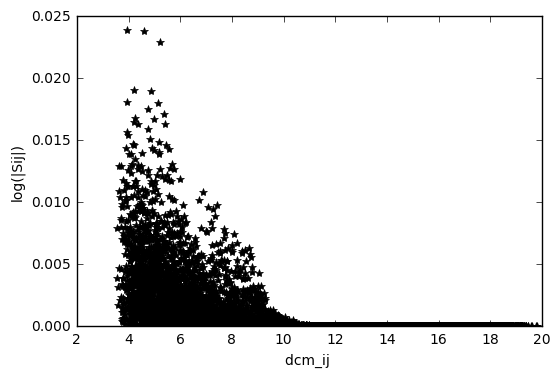

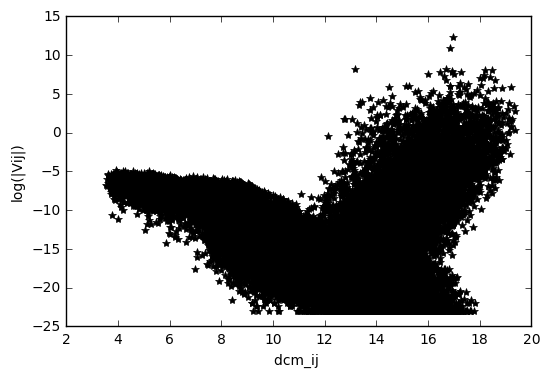

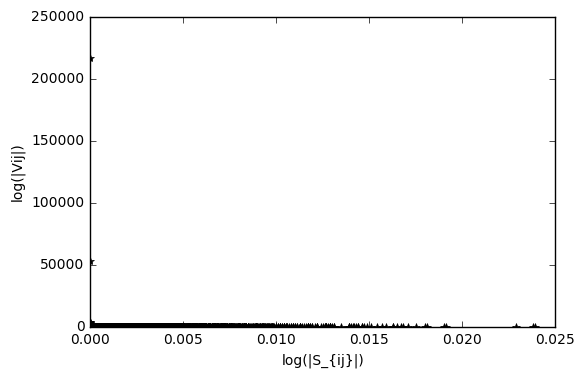

In [310]:
plot_1(calc_i.df_etdr,calc_i.properties['name'])

In [148]:
def plot_2(calc_i):    
    ms = 3
    led_x = 0.01
    led_y = 0.6
    fontsz_leg = 12
    fontsz_text = 12
    print str(calc_i.properties['name'])
    
    absSij_DA = calc_i.et_DA['absSij'].values
    #absSij_DA.append(calc_i.et_DA['absSji'].values)
    rij_DA = calc_i.et_DA['dcm_ij'].values
    #rij_DA += calc_i.et_DA['dcm_ij'].values

    absSij_DD = calc_i.et_DD['absSij'].values
    #absSij_DD += calc_i.et_DD['absSji'].values
    rij_DD = calc_i.et_DD['dcm_ij'].values
    #rij_DD += calc_i.et_DD['dcm_ij'].values
    
    absSij_AA = calc_i.et_AA['absSij'].values
    #absSij_AA += calc_i.et_AA['absSji'].values
    rij_AA = calc_i.et_AA['dcm_ij'].values
    #rij_AA += calc_i.et_AA['dcm_ij'].values

    fig,ax = plt.subplots(3,sharex=True)
    ax[2].set_xlabel(r'$dcm_{ij}$')
    ax[1].set_ylabel(r'$|S_{ij}|$')

    ax[0].plot(rij_DD,absSij_DD,'*k',label="DD")
    ax[1].plot(rij_DA,absSij_DA,'sr',label="DA")
    ax[2].plot(rij_AA,absSij_AA,'^b',label="AA")
    
    ax[0].text(10.0,0.10,"%s (DD)"%calc_i.properties['name'])
    ax[1].text(10.0,0.10,"%s (DA)"%calc_i.properties['name'])
    ax[2].text(10.0,0.10,"%s (AA)"%calc_i.properties['name'])
    
    ax[0].set_yscale('log')
    ax[1].set_yscale('log')
    ax[2].set_yscale('log')

    ax[0].set_ylim([10e-7,10e-1])
    ax[1].set_ylim([10e-7,10e-1])
    ax[2].set_ylim([10e-7,10e-1])

    ax[0].set_xlim([3,12])
    ax[1].set_xlim([3,12])
    ax[2].set_xlim([3,12])
    
    i=0
    labels=ax[i].get_yticks().tolist()
    labels[-2]=''
    ax[i].set_yticklabels(labels)    
    i=1
    labels=ax[i].get_yticks().tolist()
    labels[-2]=''
    ax[i].set_yticklabels(labels)    
    i=2
    labels=ax[i].get_yticks().tolist()
    labels[-2]=''
    ax[i].set_yticklabels(labels)    
    
    
    fig.subplots_adjust(hspace=0.0)   

    fig.savefig('%s_dr_logSij.pdf'%(calc_i.properties['name']),format='pdf')

PTB5
BDT-TPD
PTB1


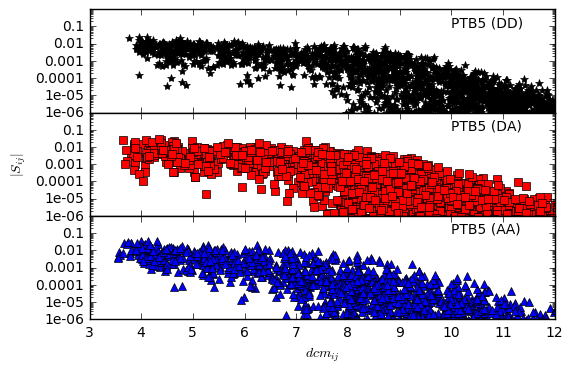

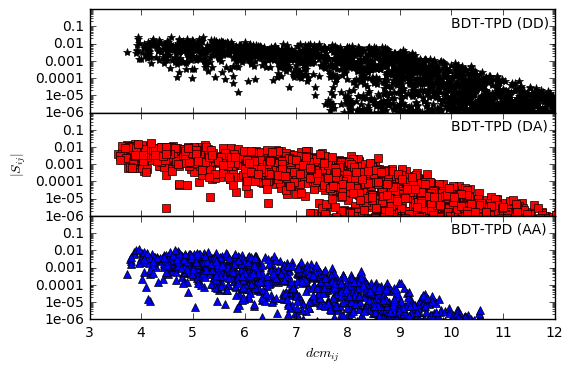

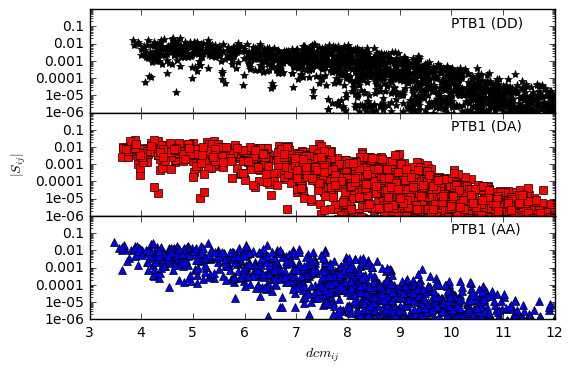

In [162]:
for tag_i,calc_i in proj_i.calculations.iteritems():
    if( calc_i.meta['status'] == 'finished' ):
        plot_2(calc_i)

In [167]:
print proj_i.calculations.keys()

['D1_R2R200_A23_R4_n1_R41n1R41n1R41n1__n5_x193_prod1_min2_grp1_remin1_res_et2', 'D1_R2R200_A23_R4_n1_R41n1R41n1R40n1__n5_x193_prod1_min2_grp1_remin1_res_et2', 'D1_R2R200_A31_R4_n1_R41n1R41n1R40n1__n5_x193_prod1_min2_grp1_remin1_res_et2', 'D1_R2R200_A2_R3_R200R200R201_n5_x197_prod1_min2_grp1_remin1_res_et2', 'D1_R2R200_A31_R4_n1_R40n1R40n1R42n1__n5_x173_prod1_min2_grp1_remin1_res_et2', 'D51_00R300R3_A23_R4__n1wB_R41n1wBR41n1wBR41n1wB__n5_x173_prod1_min2_grp1_remin1_res_et2']


In [188]:
calc_i = proj_i.calculations['D1_R2R200_A2_R3_R200R200R201_n5_x197_prod1_min2_grp1_remin1_res_et2']
print calc_i.tag,calc_i.properties['name']

D1_R2R200_A2_R3_R200R200R201_n5_x197_prod1_min2_grp1_remin1_res_et2 BDT-TPD


In [194]:
absSij_DA = np.concatenate([calc_i.et_DA['absSij'].values,calc_i.et_DA['absSji'].values])
Vij_DA = np.concatenate([calc_i.et_DA['Vij'].values,calc_i.et_DA['Vji'].values])

In [195]:
print len(calc_i.et_DA['absSij'].values)
print len(calc_i.et_DA['absSji'].values)
print len(absSij_DA)

7619
7619
15238


In [223]:
print constants.k
print constants.hbar

1.38064852e-23
1.05457180014e-34


In [237]:
    pi = constants.pi
    hbar = constants.hbar
    kB = 8.6173303e-5 #constants.k

    print kB

8.6173303e-05


In [246]:
Vij = Vij_DA[0]
l = 0.5
dG = 0.0 
T = 300.0 
kij = calc_kij(Vij,l,dG,T)

print kij


0.0287910629
1.04069831605e+12


In [220]:
constants.hbar

1.0545718001391127e-34